In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la

import seaborn as sn
import matplotlib.font_manager as fm

font_path = "/Users/pedrobraga/Documents/Cambridge/wa_two/cmunci.ttf"
custom_font = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = custom_font.get_name()
sn.set(font=custom_font.get_name())

sn.set_theme(context='notebook', style='whitegrid', palette='rocket_r', font_scale=1, color_codes=True, rc=None)

In [398]:
# --- import eigenvalues and eigenvectors calculated previously --- #

eigenvalues = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvalues5.txt')
eigenvectors = np.loadtxt('/Users/pedrobraga/Documents/Cambridge/wa_two/repo_wa_two/excitonic_states/Eigenvectors5.txt')

Mo = pd.read_csv('/Users/pedrobraga/Downloads/Eigen_vectors.csv')

In [386]:
# --- global variables --- #

hbar = 0.658 # eV fs
m0 = 5.6856800 # fs2 eV/nm2
mu = 0.108 * m0 # fs2 eV/nm2
kb = 8.681e-4 # ev K {-1}

veps0 = 5.52638e-2 # c{2} eV{-1} mum{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
A = Lwell**2 # nm{2}
r0 = Lwell * vepsW/(2*vepsS) # nm

EgZero = 2.565 # ev - zero temperature bandgap energy
n = 1.82 # dimless - refractive index of the medium 
M = 0.44 * m0 # fs2 eV/nm2 - total exciton mass
Msigma = 8 # fs ev nm{-1} - optical matrix element for interband transition
GammaZero = 0.0067 # eV - defect-induced line widgth at T = 0K

DAC = 1.9 # eV - deformation potential for acoustic phonons
DOP = 158 # eV/nm - deformation potential for optical phonons

cAC = 2100 # m/s - acoustic phonon charactetistic velocity
c0 = 299.792 # nm/fs - speed of light in vacuum
hwOP = 35 # meV - optical phonon scattering

alphaOne = -1e-4 # material specific constant for Varshni shift
alphaTwo = 300 # material specific constant for Varshni shift

# --- simulation variables --- #

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)
energies = np.linspace(-2, 3, 10000)

In [399]:
Mo

,8.279787964915277,28.26308222958213,55.16309729109149,92.29067808540084,142.73003955448658,-213.94194786392976,-317.16271944243937,-471.0146493708418,690.0464129036171,-911.8679809497717,...,0.0062369417270568125,-0.005881235911084468,0.005509303732164232,0.005121631592275945,-0.0047196758104539405,0.004306031195772931,-0.0038843118411758626,0.0034583635422613707,-0.0030298078951325634,-0.002588764857924996
0,8.265220,28.010960,53.911333,88.066942,130.951195,-184.081832,-245.272154,-302.906338,313.865936,-180.050923,...,0.006243,-0.005887,0.005515,0.005127,-0.004724,0.004310,-0.003888,0.003462,-0.003033,-0.002591
1,8.259103,27.895162,53.269299,85.659748,123.633900,-164.559465,-198.207543,-200.456874,123.429893,69.418565,...,0.006246,-0.005890,0.005517,0.005129,-0.004726,0.004312,-0.003890,0.003463,-0.003034,-0.002592
2,8.255096,27.809711,52.734360,83.464743,116.594716,-145.550047,-154.007690,-113.768715,-5.040840,160.286246,...,0.006248,-0.005891,0.005519,0.005130,-0.004728,0.004313,-0.003891,0.003464,-0.003035,-0.002593
3,8.251975,27.734293,52.212025,81.194806,109.167221,-125.835955,-110.974479,-40.204059,-84.374044,156.940721,...,0.006249,-0.005892,0.005520,0.005131,-0.004729,0.004314,-0.003892,0.003465,-0.003035,-0.002594
4,8.249285,27.661379,51.668198,78.755792,101.194215,-105.406562,-69.951281,18.457395,-120.527800,101.865042,...,0.006250,-0.005894,0.005521,0.005132,-0.004729,0.004315,-0.003892,0.003465,-0.003036,-0.002594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.987533,-0.444695,0.252413,-0.165881,0.119048,0.090388,-0.071272,0.057576,0.047100,0.038950,...,-9.901362,10.388995,-9.456994,-5.282054,-4.979654,22.620674,-32.979157,-27.897952,-5.775816,-0.298611
495,0.979667,-0.440060,0.249646,-0.164030,0.117709,0.089367,-0.070465,0.056923,0.046565,0.038507,...,-9.088108,10.418342,-11.555830,-11.780331,9.436790,-1.236123,-17.181903,39.227306,21.238263,-2.617139
496,0.971420,-0.435198,0.246744,-0.162089,0.116304,0.088296,-0.069618,0.056238,0.046004,0.038042,...,-7.649292,9.023473,-10.652910,-12.431459,13.949908,-14.015707,9.526031,6.629440,-43.131943,11.287350
497,0.962385,-0.429858,0.243555,-0.159956,0.114761,0.087119,-0.068688,0.055485,0.045388,0.037532,...,-6.035155,7.122824,-8.515120,-10.296873,12.544891,-15.250165,18.051537,-19.285292,12.058010,-38.515473


In [387]:
def BandGapEnergy(mu, T):
    return (EgZero - (alphaOne*T**2)/(alphaTwo + T)) + eigenvalues[mu]

def RadiativeRecom(mu, eigenvalues, eigenvectors): # Temperature independent radiactive recombination of eletrons
    wavefunction = FFT(mu, eigenvectors)
    C = (hbar**2 * Msigma**2) / (2 * m0**2 * veps0 * A * n * c0)

    return C * wavefunction / eigenvalues[mu]

def FFT(mu, eigenvectors): # inverse fourier transform of the amplitude of the wavefunctions
    C = A * dk / (2*np.pi)
    integral = np.sum(eigenvectors[mu][-500:] * k_vals)

    return (C * integral)**2

def Boltzmann(T, mu, eigenvalues):
    ZVec = np.sum(np.exp(eigenvalues/(kb*T)))
    BVec = np.exp(eigenvalues[mu]/(kb*T))/ZVec

    return BVec

Density functional theory and classical molecular dynamics simulations allow for assign-
ing the additional photoluminescence peak to the presence of molecularly disordered orthorhombic domains and
also rationalize that the unusual blueshift of the bandgap with increasing temperature is due to the stabilization of
the valence band maximum. Our findings provide new insights into the salient emission properties of perovskite
materials, which define their performance in solar cells and light-emitting devices - https://doi.org/10.1126/sciadv.1601156

In [388]:
for i in [0,1,2,3,4]:
    print((RadiativeRecom(i, eigenvalues, eigenvectors)))

0.0012217210318582288
0.0003673592396687041
0.00022493898524924785
0.00016508154810161046
0.00013141522619413492


In [389]:
for i in [0,1,2,3,4]:
    print((RadiativeRecom(i, eigenvalues, eigenvectors) + GammaZero)**2)

6.2753664106585e-05
4.994756662253061e-05
4.7954779949424885e-05
4.7129344662085204e-05
4.666823399267706e-05


In [394]:
for i in [0,1,2,3,4]:
    print(FFT(i, eigenvectors))

0.00581888080349709
0.00036816282377533923
9.608355180506791e-05
3.8589297463867367e-05
1.9192549031102796e-05


In [391]:
def Photoluminescence(energy_range, T, eigenvalues, eigenvectors):

    PL = []
    C = 2 * Msigma**2 / hbar

    for E in energy_range:
        I = 0

        for mu in range(len(eigenvalues)):

            B = FFT(mu, eigenvectors) * RadiativeRecom(mu, eigenvalues, eigenvectors) * Boltzmann(T, mu, eigenvalues)
            denominator = (BandGapEnergy(mu, T) - E)**2 + (RadiativeRecom(mu, eigenvalues, eigenvectors) + GammaZero)**2
            I += B/denominator

        PL.append(C*I)

    return PL

In [392]:
PL1000 = Photoluminescence(energies, 1000, eigenvalues, eigenvectors)
PL300 = Photoluminescence(energies, 300, eigenvalues, eigenvectors)
PL200 = Photoluminescence(energies, 200, eigenvalues, eigenvectors)
PL100 = Photoluminescence(energies, 100, eigenvalues, eigenvectors)
PL50 = Photoluminescence(energies, 50, eigenvalues, eigenvectors)
PL10 = Photoluminescence(energies, 10, eigenvalues, eigenvectors)

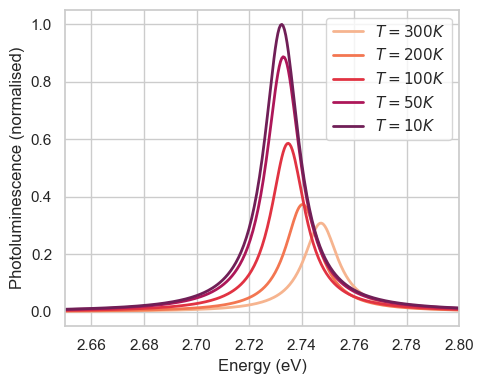

In [393]:
fig = plt.figure(figsize=(5,4))
#plt.plot(energies, np.array(PL1000)/22.032885532381822, label='$T = 1000 K$', linewidth=2)
plt.plot(energies, np.array(PL300)/22.032885532381822, label='$T = 300 K$', linewidth=2)
plt.plot(energies, np.array(PL200)/22.032885532381822, label='$T = 200 K$', linewidth=2)
plt.plot(energies, np.array(PL100)/22.032885532381822, label='$T = 100 K$', linewidth=2)
plt.plot(energies, np.array(PL50)/22.032885532381822, label='$T = 50 K$', linewidth=2)
plt.plot(energies, np.array(PL10)/22.032885532381822, label='$T = 10 K$', linewidth=2)
plt.xlabel('Energy (eV)')
plt.ylabel('Photoluminescence (normalised)')
plt.xlim(2.65, 2.8)

plt.tight_layout()
plt.legend()
plt.savefig('PL.pdf', dpi=600)

In [ ]:
def fwhm(x: np.ndarray, y: np.ndarray) -> float:
    
    half_max = np.max(y) / 2 
    indices = np.where(y >= half_max)[0]
    
    x1 = np.interp(half_max, [y[indices[0] - 1], y[indices[0]]], [x[indices[0] - 1], x[indices[0]]])
    x2 = np.interp(half_max, [y[indices[-1]], y[indices[-1] + 1]], [x[indices[-1]], x[indices[-1] + 1]])
    
    return x2 - x1